In [40]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from os.path import expanduser
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from pprint import pprint
from factslab.utility.lcsreader import LexicalConceptualStructureLexicon
from factslab.utility import ridit, r1_score

home = expanduser('~')
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', -1)

# Load the data

In [7]:
pred_datafile = home + "/Research/protocols/data/pred_raw_data_norm_122218.tsv"
pred_data = pd.read_csv(pred_datafile, sep="\t")

arg_datafile = home + "/Research/protocols/data/noun_raw_data_norm_122218.tsv"
arg_data = pd.read_csv(arg_datafile, sep="\t")

# Concreteness correlations

In [4]:
# Split the datasets into train, dev, test
conc_data = arg_data[arg_data['Split'].isin(['train', 'dev'])]

path = home + "/Research/protocols/data/concreteness.tsv"
concreteness = pd.read_csv(path, sep="\t")
list_of_lemmas = concreteness['Word'].values.tolist()

abs_conc = conc_data.groupby('Lemma')['Is.Abstract.Norm'].mean().to_frame().reset_index()
abs_conc['Concreteness'] = abs_conc['Lemma'].map(lambda x: concreteness[concreteness['Word'] == x.lower()]['Conc.M'].values[0] if x.lower() in list_of_lemmas else -1)

ini = len(abs_conc)
abs_conc = abs_conc[abs_conc['Concreteness'] != -1]
print("Percentage of lemmas found in database:", len(abs_conc) / ini)
print("Spearman correlation: ", np.round(spearmanr(abs_conc['Is.Abstract.Norm'].values, abs_conc['Concreteness'].values)[0], 2))
print("Pearson correlation: ", np.round(pearsonr(abs_conc['Is.Abstract.Norm'].values, abs_conc['Concreteness'].values)[0], 2))

Percentage of lemmas found in database: 0.6633102580239144
Spearman correlation:  -0.46
Pearson correlation:  -0.45


# LCS

In [5]:
path = home + "/Research/protocols/data/verbs-English.lcs"
lcs = LexicalConceptualStructureLexicon(path)

# Split the datasets into train, dev, test
lcs_data = pred_data[pred_data['Split'].isin(['train', 'dev'])]

dyn_lcs = lcs_data.groupby('Lemma')['Is.Dynamic.Norm'].apply(list).to_frame().reset_index()
dyn_lcs['lcs'] = dyn_lcs['Lemma'].map(lambda x: lcs.eventive(x.lower()) if x.lower() in lcs.verbs else -1)
num_of_lemmas = len(dyn_lcs)
dyn_lcs = dyn_lcs[dyn_lcs['lcs'] != -1]
dyn_lcs.set_index('Lemma', inplace=True)
dyn_lcs['dyn'] = dyn_lcs['Is.Dynamic.Norm'].apply(lambda x: [a > 0 for a in x])
dyn_lcs['comp'] = dyn_lcs.apply(lambda x: 1 if set(x['dyn']).intersection(set(x['lcs'])) else 0, axis=1)

print("Percentage of lemmas found in lcs database:", len(dyn_lcs) / num_of_lemmas)
print("They share at least one sense:", sum(dyn_lcs['comp']) / len(dyn_lcs))

Percentage of lemmas found in lcs database: 0.43727794479365945
They share at least one sense: 0.861875


# Factuality

In [8]:
datafile_ = home + "/Research/protocols/data/it-happened_eng_ud1.2_07092017_normalized.tsv"
fact_data = pd.read_csv(datafile_, sep="\t")

pred_data_f = pred_data[pred_data['Split'].isin(['train', 'dev'])]
pred_data_f['Sentence.ID'] = pred_data_f['Sentence.ID'].str.replace('sent_', '', regex=False)
pred_data_f['Unique.ID'] = pred_data_f.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Root.Token"]), axis=1)
pred_data_f = pred_data_f.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)

fact_data = fact_data[fact_data['Split'].isin(['train', 'dev'])]
fact_data['Unique.ID'] = fact_data.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Pred.Token"] - 1), axis=1)
fact_data = fact_data.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)

hyp_fact = pred_data_f.loc[:, ['Unique.ID', 'Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']]
fact_ids = fact_data['Unique.ID'].tolist()
hyp_fact['Happened.Norm'] = hyp_fact['Unique.ID'].apply(lambda x: fact_data[fact_data['Unique.ID'] == x]['Happened.Norm'].iloc[0] if x in fact_ids else None)
hyp_fact2 = hyp_fact.dropna()
print("Overlap percentage", np.round(len(hyp_fact2) / len(hyp_fact), 2))
# asdf = hyp_fact2[(hyp_fact2['Is.Hypothetical.Norm']>1) & (hyp_fact2['Happened.Norm']<-1)]
for attr in ['Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']:
    print(attr)
    print("Spearman correlation: ", np.round(spearmanr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))
    print("Pearson correlation: ", np.round(pearsonr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))

/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Overlap percentage 0.78
Is.Hypothetical.Norm
Spearman correlation:  -0.26
Pearson correlation:  -0.25
Is.Particular.Norm
Spearman correlation:  0.12
Pearson correlation:  0.11
Is.Dynamic.Norm
Spearman correlation:  0.03
Pearson correlation:  0.02


# Plot Bars

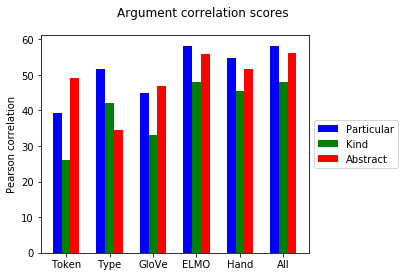

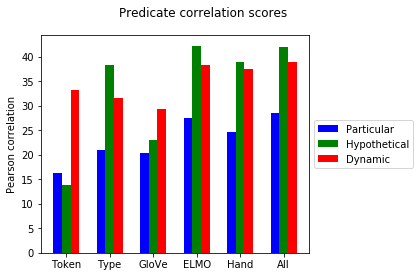

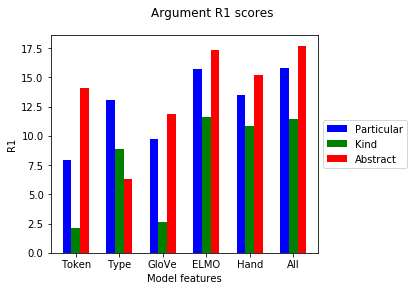

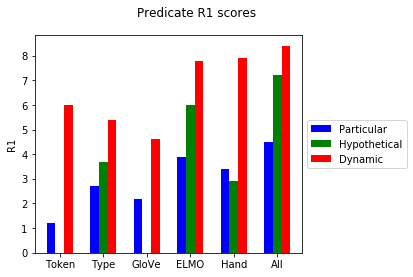

In [9]:
x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [39.2, 51.6, 44.8, 58.2, 54.8, 58.0]
y_kind = [26.0, 42.0, 33.1, 47.9, 45.6, 48.0]
y_abs = [49.2, 34.4, 46.9, 55.8, 51.6, 56.2]

plt.figure()
plt.suptitle('Argument correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [16.3, 20.9, 20.3, 27.5, 24.7, 28.5]
y_hyp = [13.8, 38.3, 22.9, 42.2, 38.8, 42.0]
y_dyn = [33.2, 31.5, 29.4, 38.3, 37.5, 38.8]

plt.figure()
plt.suptitle('Predicate correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [7.9, 13.1, 9.7, 15.7, 13.5, 15.8]
y_kind = [2.1, 8.9, 2.6, 11.6, 10.8, 11.4]
y_abs = [14.1, 6.3, 11.9, 17.3, 15.2, 17.7]

plt.figure()
plt.suptitle('Argument R1 scores')
ax = plt.subplot(111)
ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-r1.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [1.2, 2.7, 2.2, 3.9, 3.4, 4.5]
y_hyp = [0, 3.7, 0, 6.0, 2.9, 7.2]
y_dyn = [6.0, 5.4, 4.6, 7.8, 7.9, 8.4]

plt.figure()
plt.suptitle('Predicate R1 scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-r1.png')

# SPR

In [17]:
home = expanduser('~')
attr_map = {"part": "Is.Particular", "kind": "Is.Kind", "abs": "Is.Abstract"}
attr_conf = {"part": "Part.Confidence", "kind": "Kind.Confidence",
         "abs": "Abs.Confidence"}
attrs = ["part", "kind", "abs"]
attributes = ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']

arg_data_spr = arg_data.copy()
arg_data_spr['Sentence.ID'] = arg_data_spr['Sentence.ID'].str.replace('sent_', '', regex=False)
arg_data_spr['Unique.ID'] = arg_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Span']).split(',')[0] + "_" + str(x['Span']).split(',')[-1], axis=1)
arg_data_spr = arg_data_spr.dropna()
arg_data_spr = arg_data_spr[arg_data_spr['Split'].isin(['train', 'dev'])]
arg_data_spr = arg_data_spr.groupby('Unique.ID', as_index=True).mean()

datafile_ = home + "/Research/protocols/data/spr/protoroles_eng_ud1.2_11082016.tsv"
spr = pd.read_csv(datafile_, sep="\t")
# pred_data token is 0 indexed in SPR
spr['Unique.ID'] = spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Arg.Tokens.Begin"]) + "_" + str(x["Arg.Tokens.End"]), axis=1)
spr = spr[~spr['Is.Pilot']]
spr = spr.dropna()

spr = spr[spr['Split'].isin(['train', 'dev'])]

properties = ['volition', 'awareness', 'sentient', 'change_of_location', 'instigation',
              'change_of_state', 'was_used', 'change_of_possession', 'partitive',
              'was_for_benefit', 'existed_before', 'existed_during', 'existed_after']

print("Arg\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()

    for attr in attributes:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: arg_data_spr.loc[x][attr] if x in arg_data_spr.index else None)

    prop_df = prop_df.dropna()
    print(prop.replace('_', ' '), 
          '&', np.round(pearsonr(prop_df[attributes[0]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(pearsonr(prop_df[attributes[1]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(pearsonr(prop_df[attributes[2]].values, prop_df['Response.ridit'].values)[0], 2), "\\\\")

attributes = ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']

pred_data_spr = pred_data.copy()
pred_data_spr['Sentence.ID'] = pred_data['Sentence.ID'].str.replace('sent_', '', regex=False)

lst_col = 'Context.Span'
x = pred_data_spr.assign(**{lst_col: pred_data[lst_col].str.split(';')})
pred_data_spr = pd.DataFrame({col: np.repeat(x[col].values, x[lst_col].str.len()) for col in x.columns.difference([lst_col])}).assign(**{lst_col: np.concatenate(x[lst_col].values)})[x.columns.tolist()]
pred_data_spr['Unique.ID'] = pred_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Context.Span']).split(',')[0] + "_" + str(x['Context.Span']).split(',')[-1], axis=1)
pred_data_spr = pred_data_spr.dropna()
pred_data_spr = pred_data_spr[pred_data_spr['Split'].isin(['train', 'dev'])]
pred_data_spr = pred_data_spr.groupby('Unique.ID', as_index=True).mean()

print("\nPred\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()
    for attr in attributes:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: pred_data_spr.loc[x][attr] if x in pred_data_spr.index else None)
    prop_df = prop_df.dropna()

    print(prop.replace('_', ' '), 
          '&', np.round(pearsonr(prop_df[attributes[0]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(pearsonr(prop_df[attributes[1]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(pearsonr(prop_df[attributes[2]].values, prop_df['Response.ridit'])[0], 2), "\\\\")

Arg

volition & 0.18 & -0.12 & -0.16 \\
awareness & 0.19 & -0.11 & -0.18 \\
sentient & 0.18 & -0.09 & -0.18 \\
change of location & 0.07 & 0.06 & -0.17 \\
instigation & 0.09 & -0.07 & -0.08 \\
change of state & -0.01 & 0.02 & -0.03 \\
was used & 0.08 & -0.02 & -0.11 \\
change of possession & -0.02 & 0.1 & -0.03 \\
partitive & -0.02 & 0.03 & -0.06 \\
was for benefit & 0.11 & -0.07 & -0.12 \\
existed before & 0.19 & -0.03 & -0.2 \\
existed during & 0.14 & -0.04 & -0.11 \\
existed after & 0.16 & -0.05 & -0.15 \\

Pred

volition & 0.0 & -0.01 & 0.05 \\
awareness & 0.01 & -0.02 & 0.05 \\
sentient & 0.01 & 0.0 & 0.03 \\
change of location & 0.02 & -0.02 & 0.05 \\
instigation & -0.01 & -0.02 & 0.04 \\
change of state & 0.01 & 0.03 & 0.03 \\
was used & 0.02 & -0.05 & 0.06 \\
change of possession & 0.01 & -0.0 & -0.01 \\
partitive & -0.01 & 0.04 & 0.02 \\
was for benefit & 0.01 & -0.01 & 0.05 \\
existed before & 0.01 & -0.01 & 0.08 \\
existed during & 0.0 & -0.03 & 0.05 \\
existed after & 0.02 

# Analysis in paper

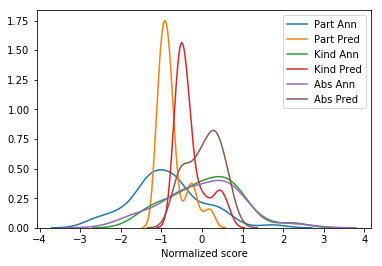

Pronomial sentences containing you/they with high Is.Kind values

2090    i think they are all bark and no bite .                                                                                                                                                                             
3534    But getting past who should get them , is who has them , and who is really close .                                                                                                                                  
1246    Not only are these people completely inefficient and ineffective , but they just do n't give a darn .                                                                                                               
2506    If you are not the intended recipient , you are hereby notified that you have received this transmittal in error ; any review , dissemination , distribution or copying of this transmittal is strictly prohibited .
328     hope they do n't call the police and arres

In [25]:
sigdig = 1
arg_dev = pd.read_csv('dev_preds_arg.tsv', sep='\t')
pred_dev = pd.read_csv('dev_preds_pred.tsv', sep='\t')

pron_df = arg_dev[arg_dev['Lemma'].isin(['you', 'they'])]
print("Pronomial sentences containing you/they with high Is.Kind values\n")
print(pron_df[pron_df['Is.Kind.Norm'] > 0]['Sentences'].sample(5), "\n")

hyp_df = pred_dev[(pred_dev['Sentences'].str.contains('if'))]
print("Conditional sentences(with if) with low Is.Hypothetical scores\n")
print(pred_dev[(pred_dev['Sentences'].str.contains('if ', regex=False)) & 
               (pred_dev['Is.Hypothetical.Pred'] < -0.3)]['Sentences'].sample(5), "\n")

## Thing words

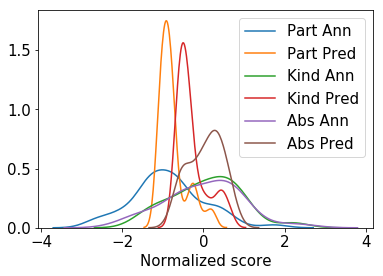

In [33]:
mpl.rcParams.update({'font.size': 15})
thing_words = arg_dev[arg_dev['Lemma'].str.contains('thing')]

plt.figure()
sns.distplot(thing_words['Is.Particular.Norm'], hist=False, label='Part Ann').get_figure()
sns.distplot(thing_words['Is.Particular.Pred'], hist=False, label='Part Pred').get_figure()
sns.distplot(thing_words['Is.Kind.Norm'], hist=False, label='Kind Ann').get_figure()
sns.distplot(thing_words['Is.Kind.Pred'], hist=False, label='Kind Pred').get_figure()
sns.distplot(thing_words['Is.Abstract.Norm'], hist=False, label='Abs Ann').get_figure()
sns.distplot(thing_words['Is.Abstract.Pred'], hist=False, label='Abs Pred').get_figure()
plt.xlabel('Normalized score')
plt.show()
# plt.savefig('things.png', transparent=True)

## POS and DEPREL

In [41]:
print("\nArg POS")
pprint([(a, len(arg_dev[arg_dev['POS'] == a])) for a in list(set(arg_dev['POS'].tolist()))])
for pos in list(set(arg_dev['POS'].tolist())):
    data_new = arg_dev[arg_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig),
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")

print("\nArg DEPREL")
pprint([(a, len(arg_dev[arg_dev['DEPREL'] == a])) for a in list(set(arg_dev['DEPREL'].tolist()))])
for deprel in list(set(arg_dev['DEPREL'].tolist())):
    data_new = arg_dev[arg_dev['DEPREL'] == deprel]
    print(deprel, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")


print("\nPred POS")
pprint([(a, len(pred_dev[pred_dev['POS'] == a])) for a in list(set(pred_dev['POS'].tolist()))])
for pos in list(set(pred_dev['POS'].tolist())):
    data_new = pred_dev[pred_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")

print("\nPred DEPREL")
pprint([(a, len(pred_dev[pred_dev['DEPREL'] == a])) for a in list(set(pred_dev['DEPREL'].tolist()))])
for deprel in list(set(pred_dev['DEPREL'].tolist())):
    data_new = pred_dev[pred_dev['DEPREL'] == deprel]
    print(deprel,
          '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")


# for pos in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['POS'] == pos]
#     data_new2 = pred_dev[pred_dev['POS'] == pos]
#     print(pos, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")

# for deprel in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['DEPREL'] == deprel]
#     data_new2 = pred_dev[pred_dev['DEPREL'] == deprel]
#     print(deprel, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")




Arg POS
[('DET', 49), ('NOUN', 2467), ('PROPN', 565), ('PRON', 490), ('NUM', 40)]
DET & 40.1 & -3.6 & 52.3 & 12.4 & 29.6 & 1.7 & 2.9 \\
NOUN & 49.9 & 15.0 & 41.1 & 8.9 & 59.8 & 20.9 & 14.9 \\
PROPN & 32.4 & -5.0 & 32.3 & 2.4 & 21.0 & -3.7 & -2.3 \\
PRON & 24.5 & 3.2 & 30.1 & 4.6 & 5.3 & -6.5 & 0.6 \\
NUM & 16.4 & 1.1 & 38.4 & 8.5 & -2.5 & -0.7 & 2.9 \\

Arg DEPREL
[('xcomp', 27),
 ('conj', 38),
 ('nmod:poss', 5),
 ('acl', 3),
 ('csubj', 2),
 ('acl:relcl', 7),
 ('dobj', 1000),
 ('nsubj', 1144),
 ('nmod:tmod', 65),
 ('nmod', 943),
 ('ccomp', 18),
 ('root', 159),
 ('appos', 4),
 ('iobj', 25),
 ('nsubjpass', 110),
 ('parataxis', 16),
 ('advmod', 2),
 ('nmod:npmod', 24),
 ('advcl', 19)]
xcomp & 56.9 & 15.8 & 32.2 & 5.8 & 32.5 & 2.9 & 7.8 \\
conj & 43.6 & 5.0 & 41.5 & 16.1 & 78.3 & 30.8 & 17.5 \\
nmod:poss & 81.9 & 13.9 & -27.4 & -4.1 & 80.0 & 11.0 & 5.6 \\
acl & 94.0 & 26.3 & -87.7 & -58.1 & 82.1 & 42.5 & -3.8 \\
csubj & 100.0 & -2536.6 & 100.0 & -5.9 & 100.0 & -33.8 & -1255.7 \\
acl:relcl